In [218]:
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy as sp
import os
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.interpolate import interp1d
import numpy as np

In [219]:
x_data = []
y_data = []
classes = {}
root = os.path.split(os.getcwd())[0]+"\\data"

In [220]:
a_sample_0 = os.path.join(root+"\\a_sample_0_1.txt")
b_sample_0 = os.path.join(root+"\\b_sample_0_1.txt")

### Now we look into the dataset, first we will consider sample a and b

In [221]:
data_raw_a = np.array([list(map(lambda x: float(x),(i.split(" ")[1:-1]))) for i in open(a_sample_0)])
data_raw_b = np.array([list(map(lambda x: float(x),(i.split(" ")[1:-1]))) for i in open(b_sample_0)])

In [222]:
data_raw_a[0:5]

array([[ 24236.,  11800.,  17564.,  10104.,  -1929.,   3870.],
       [ 14148.,   6652.,  25064.,  13396.,  -3673.,    980.],
       [ 19240.,   6208.,  22396.,  19292.,  -4424.,  -5415.],
       [ 17716.,   5300.,  18644.,  23330.,  -5363., -10751.],
       [ 17076.,   4188.,  12380.,  24391.,  -3254., -14020.]])

In [223]:
data_raw_a.shape

(58, 6)

In [224]:
data_raw_b.shape

(65, 6)

### The shape of the sample depends on the readings from the acc + gyro (MPU6050). So we need make this same for all type of samples

In [225]:
import matplotlib.pyplot as plt
%matplotlib inline

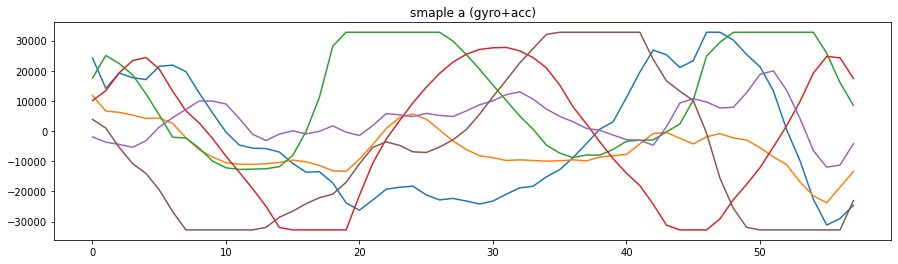

In [226]:
plt.figure(figsize=(15,4))
plt.subplot(1,1,1)
plt.plot(range(0,len(data_raw_a)),data_raw_a)
plt.title("smaple a (gyro+acc)")
plt.show()

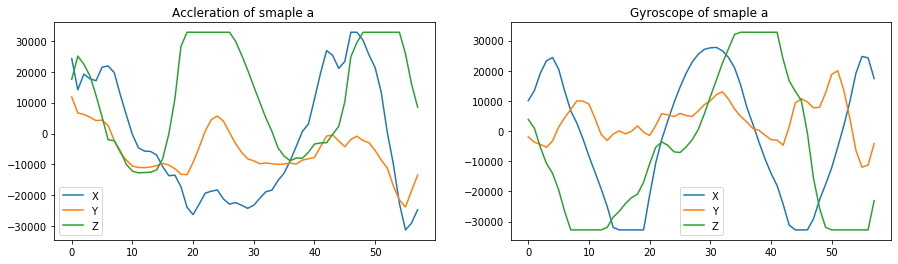

In [227]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(range(0,len(data_raw_a)),data_raw_a[:,0:3])
plt.title("Accleration of smaple a ")
plt.legend("XYZ")
plt.subplot(1,2,2)
plt.plot(range(0,len(data_raw_a)),data_raw_a[:,3:])
plt.title("Gyroscope of smaple a ")
plt.legend("XYZ")
plt.show()

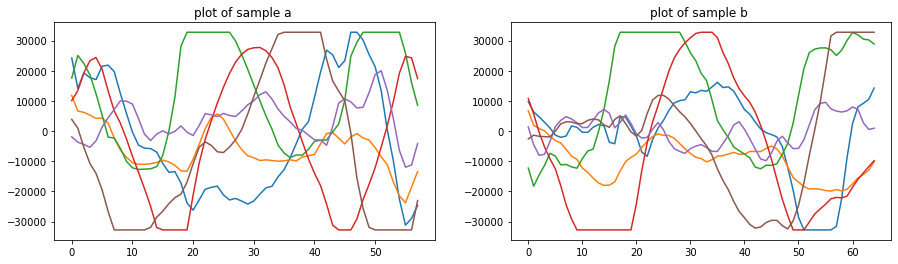

In [228]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(range(0,len(data_raw_a)),data_raw_a)
plt.title("plot of sample a ")
plt.subplot(1,2,2)
plt.plot(range(0,len(data_raw_b)),data_raw_b)
plt.title("plot of sample b ")

plt.show()

### we can clearly see there is a difference between sample a and sample b

In [229]:
data_norm = scale(data_raw_a)

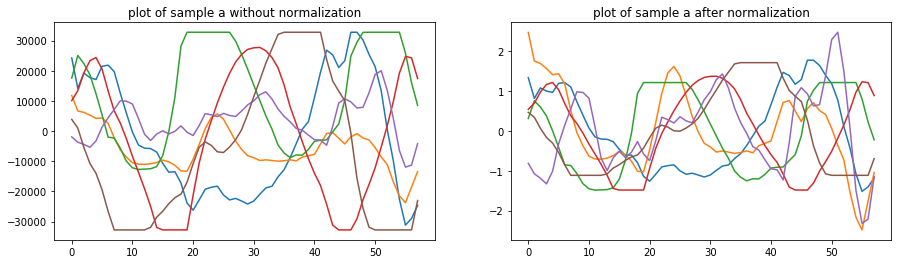

In [230]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(range(0,len(data_raw_a)),data_raw_a)
plt.title("plot of sample a without normalization")
plt.subplot(1,2,2)
plt.plot(range(0,len(data_raw_a)),data_norm)
plt.title("plot of sample a after normalization")
plt.show()

In [231]:
def load(filename,size_fit = 50):
    data_raw = [list(map(lambda x: int(x), i.split(" ")[1:-1])) for i in open(filename)]
    data = np.array(data_raw).astype(float)
    data_norm = scale(data)
    acx = data_norm[:,0]
    acy = data_norm[:,1]
    acz = data_norm[:,2]
    gx = data_norm[:,3]
    gy = data_norm[:,4]
    gz = data_norm[:,5]
    x = np.linspace(0, data.shape[0], data.shape[0])
    f_acx = interp1d(x, acx)
    f_acy = interp1d(x, acy)
    f_acz = interp1d(x, acz)
    f_gx = interp1d(x, gx)
    f_gy = interp1d(x, gy)
    f_gz = interp1d(x, gz)
    xnew = np.linspace(0, data.shape[0], size_fit)
    acx_stretch = f_acx(xnew)
    acy_stretch = f_acy(xnew)
    acz_stretch = f_acz(xnew)
    gx_stretch = f_gx(xnew)
    gy_stretch = f_gy(xnew)
    gz_stretch = f_gz(xnew)

    return np.concatenate((acx_stretch, acy_stretch, acz_stretch, gx_stretch, gy_stretch, gz_stretch))

In [232]:
data_inter = load(a_sample_0,50).reshape(6,50)
data_inter = data_inter.transpose()

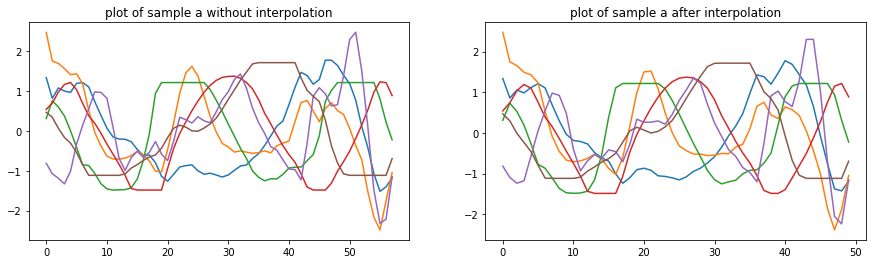

In [233]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("plot of sample a without interpolation")
plt.plot(range(0,len(data_raw_a)),data_norm)
plt.subplot(1,2,2)
plt.plot(range(0,50),data_inter)
plt.title("plot of sample a after interpolation")
plt.show()


#### The shape of different sample of same letter is different, it dependes on how many seconds you take to draw. Hence we need to make it a standard size. Here I am considering a (50,6) as a standerd size using interpolation 

In [234]:
for path, subdirs, files in os.walk(root):
    for name in files:
        filename = os.path.join(path, name)

        x_data.append(load(filename))
        category = name.split("_")[0]
        if category=="":
            category = " "
        number = ord(category) - ord("a")
        y_data.append(number)
        classes[number] = category

In [235]:
params = {'C':[0.001,0.01,0.1,1], 'kernel':['linear']}

In [236]:
svc = svm.SVC(probability = True)

In [237]:
clf = GridSearchCV(svc, params,verbose =10, n_jobs=8)

In [238]:
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=0)

In [239]:
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:   12.9s remaining:   19.4s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:   14.2s remaining:   11.6s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:   15.8s remaining:    6.7s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:   16.4s remaining:    2.8s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   17.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [240]:
print(clf.best_estimator_)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [241]:
score = clf.score(X_test, Y_test)

In [242]:
print("score: {score}".format(score=score))

score: 0.9827882960413081


### No lets test on the x_test[1] sample

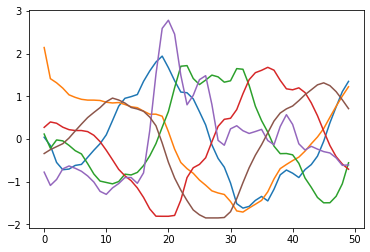

In [243]:
plt.plot(range(0,50),X_test[1].reshape(6,50).transpose())
plt.show()

In [247]:
ans = clf.predict(X_test[1].reshape(1,-1))[0]

In [248]:
classes[ans]

'o'

In [249]:
classes[Y_test[1]]

'o'